###### import os

In [2]:
os.environ["SPARK_HOME"]="/home/bof/Documents/PROJET/spark-3.5.0-bin-hadoop3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/default-java"

In [3]:
import pyspark
import psycopg2
import threading
import requests
import json
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_unixtime, date_format, hour, dayofmonth
from pyspark.sql.types import FloatType

In [4]:
# Connect to the PostgreSQL database
host = "172.17.0.2"
port = 5432
user = "postgres"
database = "db_atmo"
password = "mysecretpassword"

conn = psycopg2.connect(host=host, port=port, database=database, user=user, password=password)

cur = conn.cursor()


In [5]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


# Créer une instance de SparkSession avec les propriétés de configuration
spark = SparkSession.builder.appName("Données ATMO").config("spark.driver.extraClassPath", "/home/bof/Documents/PROJET/spark-3.5.0-bin-hadoop3/jars/postgresql-42.6.2.jar").config("spark.executor.extraClassPath", "/home/bof/Documents/PROJET/spark-3.5.0-bin-hadoop3/jars/postgresql-42.6.2.jar").getOrCreate()



24/03/27 17:32:01 WARN Utils: Your hostname, hp resolves to a loopback address: 127.0.1.1; using 192.168.0.108 instead (on interface wlp1s0)
24/03/27 17:32:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/27 17:32:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/27 17:32:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/03/27 17:32:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [6]:

# Charger les données depuis PostgreSQL
df_indice_atmo = spark.read.format("jdbc").option("url", "jdbc:postgresql://172.17.0.2:5432/db_atmo").option("dbtable", "indice_atmo").option("user", "postgres").option("password", "mysecretpassword").load()

# Charger les données depuis PostgreSQL
df_region = spark.read.format("jdbc").option("url", "jdbc:postgresql://172.17.0.2:5432/db_atmo").option("dbtable", "region").option("user", "postgres").option("password", "mysecretpassword").load()


# Charger les données depuis PostgreSQL
df_epci = spark.read.format("jdbc").option("url", "jdbc:postgresql://172.17.0.2:5432/db_atmo").option("dbtable", "epci").option("user", "postgres").option("password", "mysecretpassword").load()


# Charger les données depuis PostgreSQL
df_annee = spark.read.format("jdbc").option("url", "jdbc:postgresql://172.17.0.2:5432/db_atmo").option("dbtable", "episodes_de_pollution_constatés_sur_l’année_passée").option("user", "postgres").option("password", "mysecretpassword").load()




In [7]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_i = df_indice_atmo.toPandas()
df_r = df_region.toPandas()
df_e = df_epci.toPandas()
df_a = df_annee.toPandas()

In [16]:
null_counts = df_indice_atmo.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_indice_atmo.columns])

# Afficher les résultats
null_counts.show()

+---+--------+-------+---------+---------+---------+--------+---------+---------+--------+--------+--------+--------+--------+------+---------+-----+-------+-----+-------+
| id|code_no2|code_o3|code_pm10|code_pm25|code_qual|code_so2|code_zone|coul_qual|date_dif|date_ech|epsg_reg|lib_qual|lib_zone|source|type_zone|x_reg|x_wgs84|y_reg|y_wgs84|
+---+--------+-------+---------+---------+---------+--------+---------+---------+--------+--------+--------+--------+--------+------+---------+-----+-------+-----+-------+
|  0|       0|      0|        0|        0|        0|       0|        0|        0|       0|       0|       0|       0|       0|     0|        0|    0|      0|    0|      0|
+---+--------+-------+---------+---------+---------+--------+---------+---------+--------+--------+--------+--------+--------+------+---------+-----+-------+-----+-------+



In [17]:
null_counts1 = df_region.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_region.columns])

# Afficher les résultats
null_counts1.show()

+---+----------+----------+----+----+---+----------+---+----+
| id|superficie|population|pm25|pm10|nox|code_pcaet|ges|code|
+---+----------+----------+----+----+---+----------+---+----+
|  0|         0|         0|   0|   0|  0|         0|  0|   0|
+---+----------+----------+----+----+---+----------+---+----+



In [18]:
null_counts2 = df_epci.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_epci.columns])

# Afficher les résultats
null_counts2.show()

+---+----------+----------+----+----+---+---+----------+----+
| id|superficie|population|pm25|pm10|nox|ges|code_pcaet|code|
+---+----------+----------+----+----+---+---+----------+----+
|  0|         0|         0|   0|   0|  0|  0|         0|   0|
+---+----------+----------+----+----+---+---+----------+----+



In [19]:
null_counts3 = df_annee.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_annee.columns])

# Afficher les résultats
null_counts3.show()

+---+-------+--------+----+--------+--------+---------+--------+
| id|lib_pol|lib_zone|etat|date_ech|date_dif|code_zone|code_pol|
+---+-------+--------+----+--------+--------+---------+--------+
|  0|      0|       0|   0|       0|       0|        0|       0|
+---+-------+--------+----+--------+--------+---------+--------+



# EPCI

In [21]:
nb_lignes, nb_colonnes = df_e.shape
print("Nombre de lignes :", nb_lignes)
print("Nombre de colonnes :", nb_colonnes)

Nombre de lignes : 1245
Nombre de colonnes : 9


In [22]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1245 non-null   int32 
 1   superficie  1245 non-null   object
 2   population  1245 non-null   object
 3   pm25        1245 non-null   object
 4   pm10        1245 non-null   object
 5   nox         1245 non-null   object
 6   ges         1245 non-null   object
 7   code_pcaet  1245 non-null   object
 8   code        1245 non-null   object
dtypes: int32(1), object(8)
memory usage: 82.8+ KB


In [23]:
df_e.isnull().sum()

id            0
superficie    0
population    0
pm25          0
pm10          0
nox           0
ges           0
code_pcaet    0
code          0
dtype: int64

In [24]:
df_e.describe()

id
count  1245.000000
mean   4801.000000
std     359.544851
min    4179.000000
25%    4490.000000
50%    4801.000000
75%    5112.000000
max    5423.000000

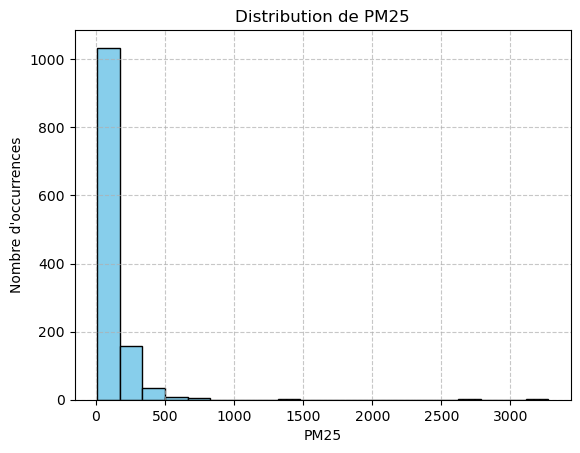

In [59]:
import matplotlib.pyplot as plt

# Histogramme pour la colonne 'pm25'
plt.hist(df_e['pm25'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('PM25')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution de PM25')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


/home/bof/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


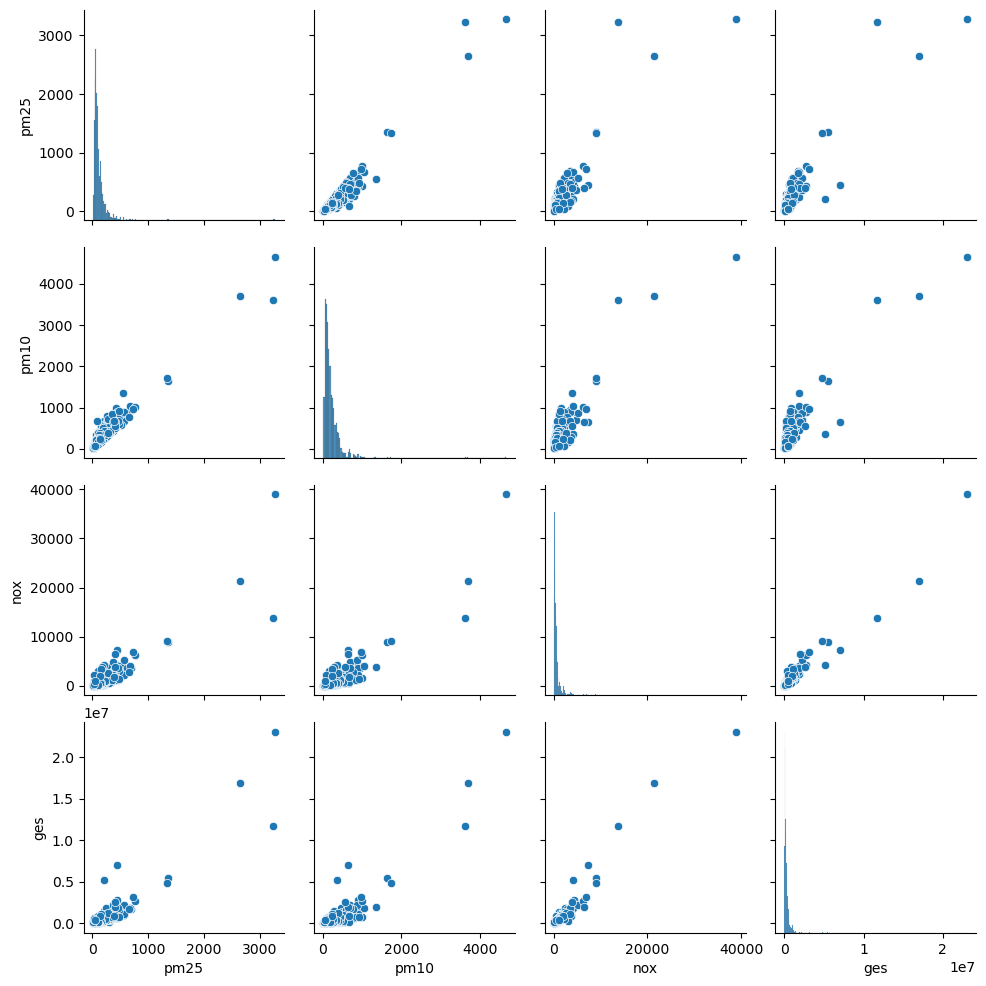

In [60]:
import seaborn as sns

# Sélection des variables d'intérêt
variables = ['pm25', 'pm10', 'nox', 'ges']

# Créer un pairplot
sns.pairplot(df_e[variables])
plt.show()


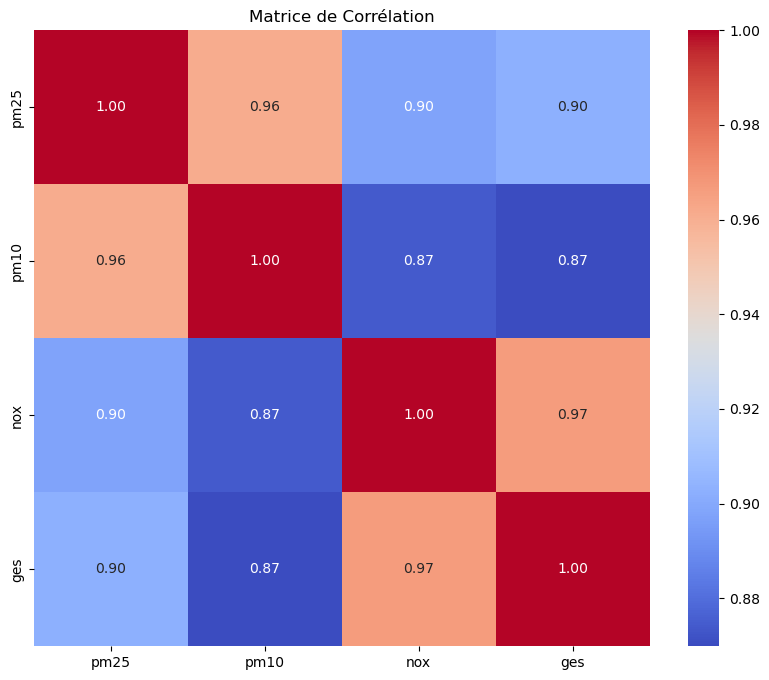

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
correlation_matrix = df_e[variables].corr()

# Créer un heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matrice de Corrélation')
plt.show()


# Constatés sur l'année passée

In [27]:
nb_lignes, nb_colonnes = df_a.shape
print("Nombre de lignes :", nb_lignes)
print("Nombre de colonnes :", nb_colonnes)

Nombre de lignes : 1688
Nombre de colonnes : 8


In [28]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1688 non-null   int32 
 1   lib_pol    1688 non-null   object
 2   lib_zone   1688 non-null   object
 3   etat       1688 non-null   object
 4   date_ech   1688 non-null   object
 5   date_dif   1688 non-null   object
 6   code_zone  1688 non-null   object
 7   code_pol   1688 non-null   object
dtypes: int32(1), object(7)
memory usage: 99.0+ KB


In [29]:
df_a.isnull().sum()

id           0
lib_pol      0
lib_zone     0
etat         0
date_ech     0
date_dif     0
code_zone    0
code_pol     0
dtype: int64

In [30]:
df_a.describe()

id
count  1688.000000
mean    844.500000
std     487.427943
min       1.000000
25%     422.750000
50%     844.500000
75%    1266.250000
max    1688.000000

In [31]:
# Comptage des occurrences de chaque valeur pour les colonnes catégorielles
etat_counts = df_a['etat'].value_counts()
lib_pol_counts = df_a['lib_pol'].value_counts()
print('occurences des valeur du colonne etat :')
print(etat_counts)
print('occurences des valeur du colonne lib_pol: ')
print(lib_pol_counts)

occurences des valeur du colonne etat :
etat
INFORMATION ET RECOMMANDATION    1099
ALERTE SUR PERSISTANCE            342
ALERTE                            243
ALERTE SUR PERSISTENCE              4
Name: count, dtype: int64
occurences des valeur du colonne lib_pol: 
lib_pol
Particules PM10                        629
PM10                                   384
Particules fines inférieur à 10 um     206
O3                                     196
Ozone                                  101
PARTICULES PM10                         97
Particules, diamètre < 10 µm            24
OZONE                                   21
Particules fines PM2,5                  13
Particules fines inférieur à 2.5 um     11
Dioxyde de soufre                        5
Dioxyde d'azote                          1
Name: count, dtype: int64


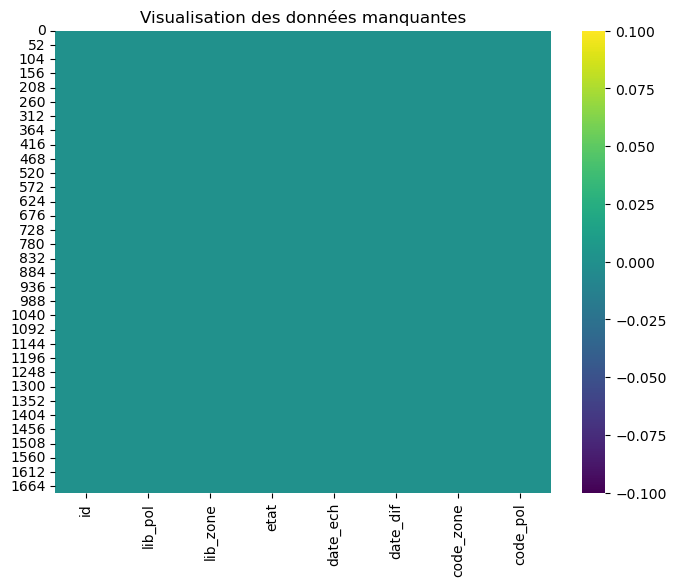

In [32]:
# Visualisation des données manquantes
import seaborn as sns
import matplotlib.pyplot as plt

# Création d'une carte thermique pour visualiser les données manquantes
plt.figure(figsize=(8, 6))
sns.heatmap(df_a.isnull(), cmap='viridis')
plt.title('Visualisation des données manquantes')
plt.show()


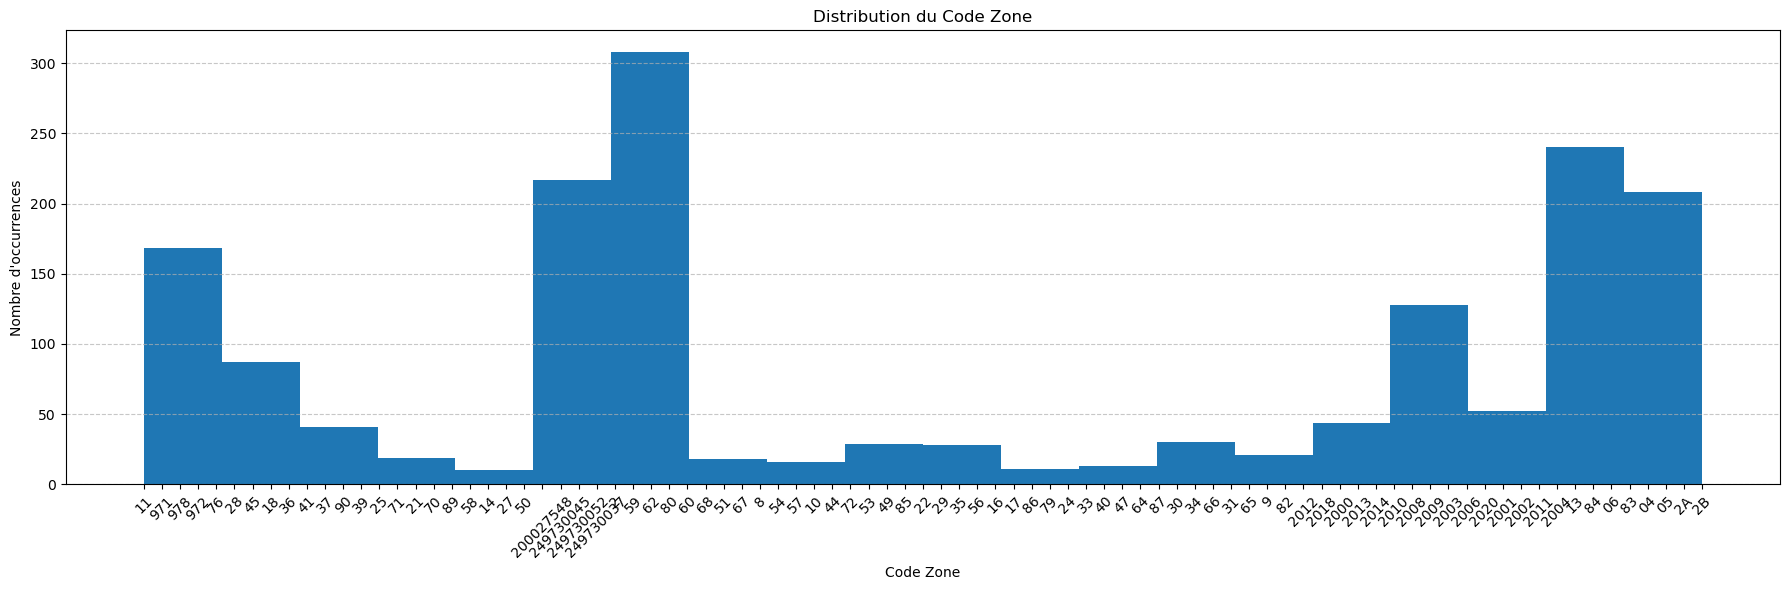

In [37]:
import matplotlib.pyplot as plt

# Histogramme pour la colonne 'code_zone'
plt.figure(figsize=(18, 6))  # Taille personnalisée de la figure
plt.hist(df_a['code_zone'], bins=20)  # Vous pouvez ajuster le nombre de bacs selon vos données
plt.xlabel('Code Zone')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution du Code Zone')
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour une meilleure visualisation
plt.tight_layout()  # Ajustement automatique de la mise en page pour éviter le chevauchement
plt.show()


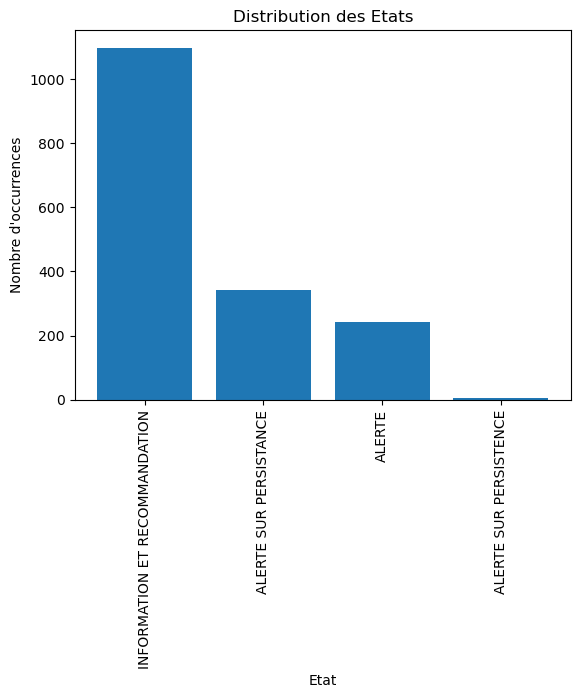

In [38]:
# Diagramme à barres pour la colonne 'etat'
plt.bar(etat_counts.index, etat_counts.values)
plt.xlabel('Etat')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des Etats')
plt.xticks(rotation=90)
plt.show()

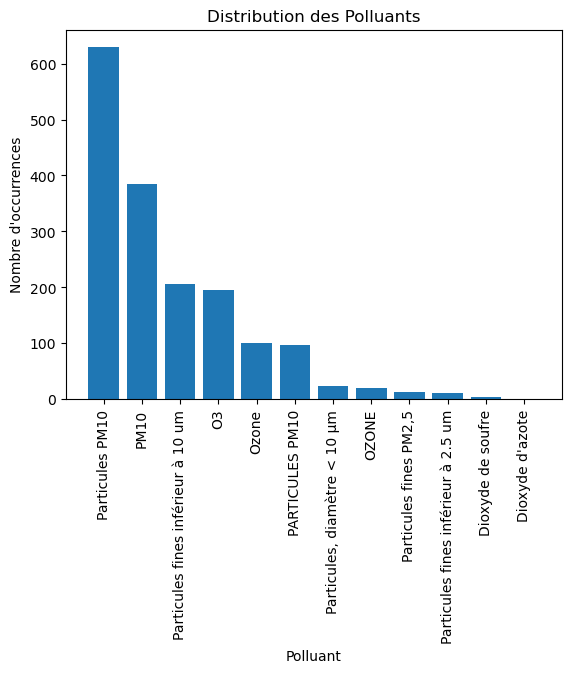

In [39]:
# Diagramme à barres pour la colonne 'lib_pol'
plt.bar(lib_pol_counts.index, lib_pol_counts.values)
plt.xlabel('Polluant')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des Polluants')
plt.xticks(rotation=90)
plt.show()

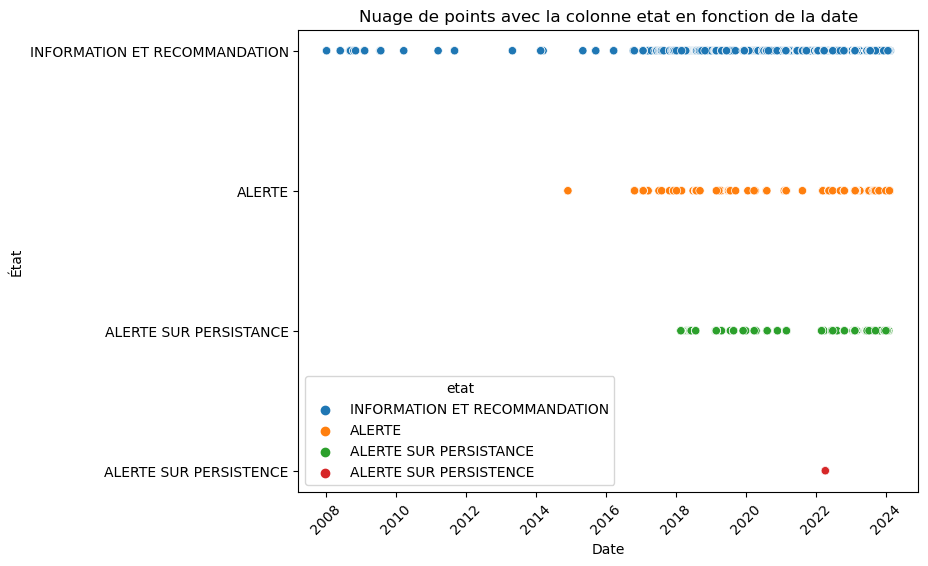

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la colonne 'date_ech' en format de date
df_a['date_ech'] = pd.to_datetime(df_a['date_ech'])

# Tracer le nuage de points en fonction de la colonne 'date_ech'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_a, x='date_ech', y='etat', hue='etat')
plt.title('Nuage de points avec la colonne etat en fonction de la date')
plt.xlabel('Date')
plt.ylabel('État')
plt.xticks(rotation=45)
plt.show()

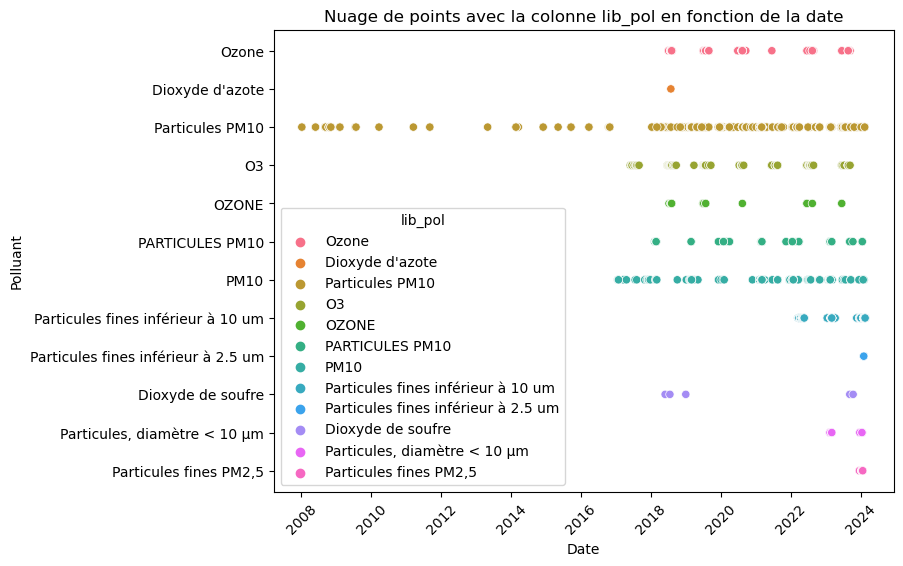

In [41]:
# Convertir la colonne 'date_ech' en format de date
df_a['date_ech'] = pd.to_datetime(df_a['date_ech'])
# Tracer le nuage de points en fonction de la colonne 'date_ech' et 'lib_pol'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_a, x='date_ech', y='lib_pol', hue='lib_pol')
plt.title('Nuage de points avec la colonne lib_pol en fonction de la date')
plt.xlabel('Date')
plt.ylabel('Polluant')
plt.xticks(rotation=45)
plt.show()


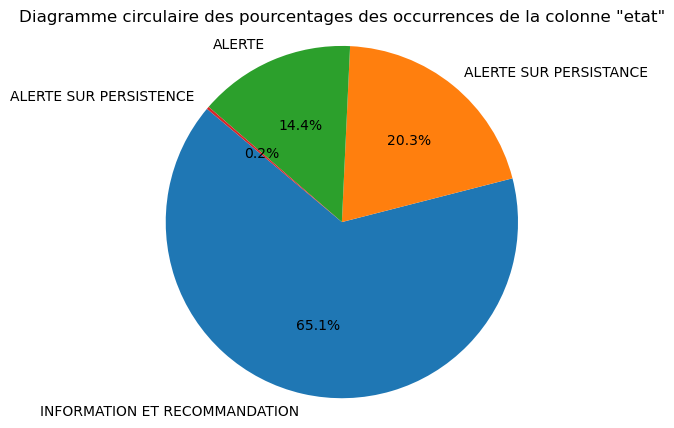

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir le DataFrame Spark en DataFrame Pandas
df_a = df_annee.toPandas()


# Calculer les occurrences de chaque état
etat_counts = df_a['etat'].value_counts()

# Créer un diagramme circulaire
plt.figure(figsize=(5, 5))
plt.pie(etat_counts, labels=etat_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Diagramme circulaire des pourcentages des occurrences de la colonne "etat"')
plt.axis('equal')
plt.show()


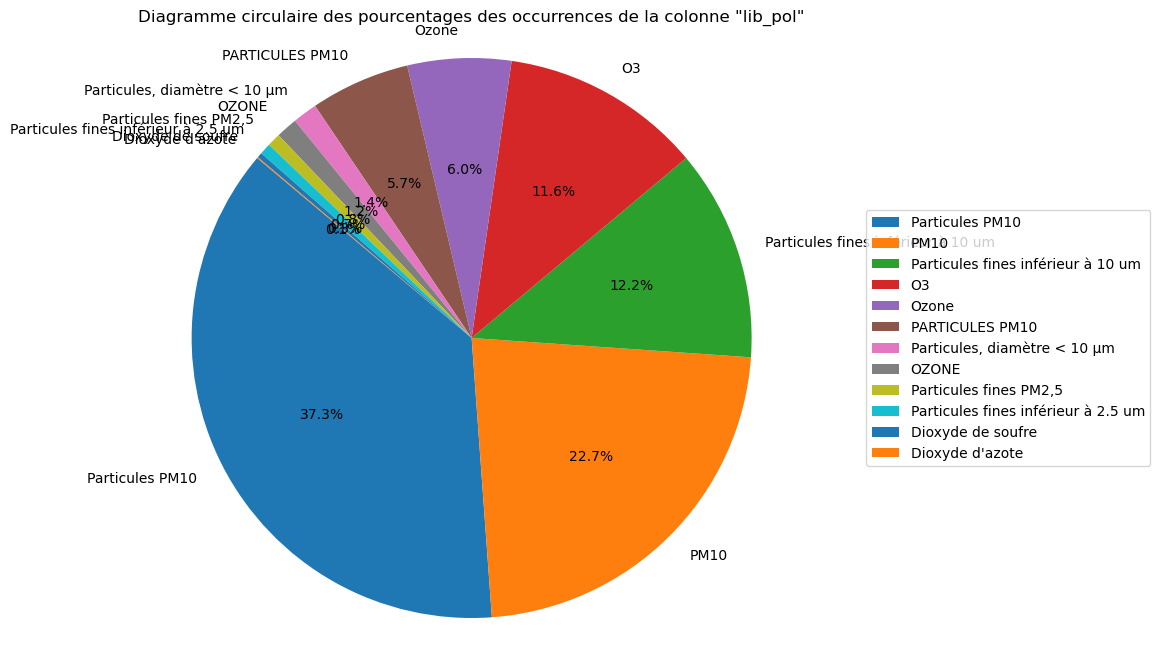

In [42]:
import matplotlib.pyplot as plt

# Calculer les occurrences de chaque polluant
lib_pol_counts = df_a['lib_pol'].value_counts()

# Créer un diagramme circulaire
plt.figure(figsize=(10, 8))
plt.pie(lib_pol_counts, labels=lib_pol_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Diagramme circulaire des pourcentages des occurrences de la colonne "lib_pol"')
plt.axis('equal')  # Assure que le diagramme est un cercle

# Ajouter une légende à côté du diagramme
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# INDICE DE QUALITE DE L'AIR

In [44]:
# Statistiques descriptives des codes de qualité
print("\nStatistiques des codes de qualité :")
print(df_i['code_qual'].describe())


Statistiques des codes de qualité :
count    2040.000000
mean        2.582353
std         0.742517
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: code_qual, dtype: float64


In [46]:
# Relation entre le code de qualité et le code de PM10
print("\nRelation entre le code de qualité et le code de PM10 :")
print(df_i.groupby('code_qual')['code_pm10'].mean())



Relation entre le code de qualité et le code de PM10 :
code_qual
1    1.000000
2    1.190265
3    1.379479
4    2.089928
5    4.000000
Name: code_pm10, dtype: float64


In [47]:
# Relation entre le code de qualité et le code de PM25
print("\nRelation entre le code de qualité et le code de PM2.5 :")
print(df_i.groupby('code_qual')['code_pm25'].mean())



Relation entre le code de qualité et le code de PM2.5 :
code_qual
1    1.000000
2    1.379646
3    1.543974
4    2.589928
5    5.000000
Name: code_pm25, dtype: float64


In [51]:
# Relation entre le code de qualité et le code de PM25
print("\nRelation entre le code de qualité et le code de code_no2 :")
print(df_i.groupby('code_qual')['code_no2'].mean())



Relation entre le code de qualité et le code de code_no2 :
code_qual
1    1.000000
2    1.361062
3    1.260586
4    1.460432
5    2.222222
Name: code_no2, dtype: float64


In [49]:
# Relation entre le code de qualité et le code de PM25
print("\nRelation entre le code de qualité et le code de code_o3 :")
print(df_i.groupby('code_qual')['code_o3'].mean())



Relation entre le code de qualité et le code de code_o3 :
code_qual
1    1.000000
2    1.853982
3    2.749186
4    3.136691
5    1.333333
Name: code_o3, dtype: float64


In [52]:
# Relation entre le code de qualité et le code de PM25
print("\nRelation entre le code de qualité et le code de code_so2 :")
print(df_i.groupby('code_qual')['code_so2'].mean())



Relation entre le code de qualité et le code de code_so2 :
code_qual
1    1.000000
2    1.002655
3    1.004886
4    1.000000
5    1.000000
Name: code_so2, dtype: float64


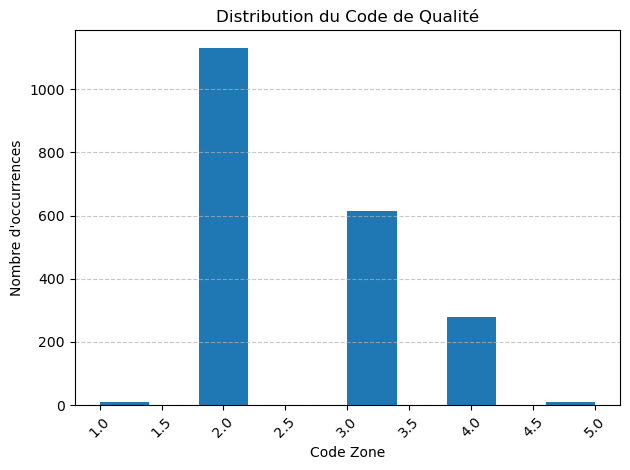

In [55]:
import matplotlib.pyplot as plt

# Histogramme pour la colonne 'code_zone'
plt.hist(df_i['code_qual'])
plt.xlabel('Code Zone')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution du Code de Qualité')
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour une meilleure visualisation
plt.tight_layout()  # Ajustement automatique de la mise en page pour éviter le chevauchement
plt.show()


/home/bof/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


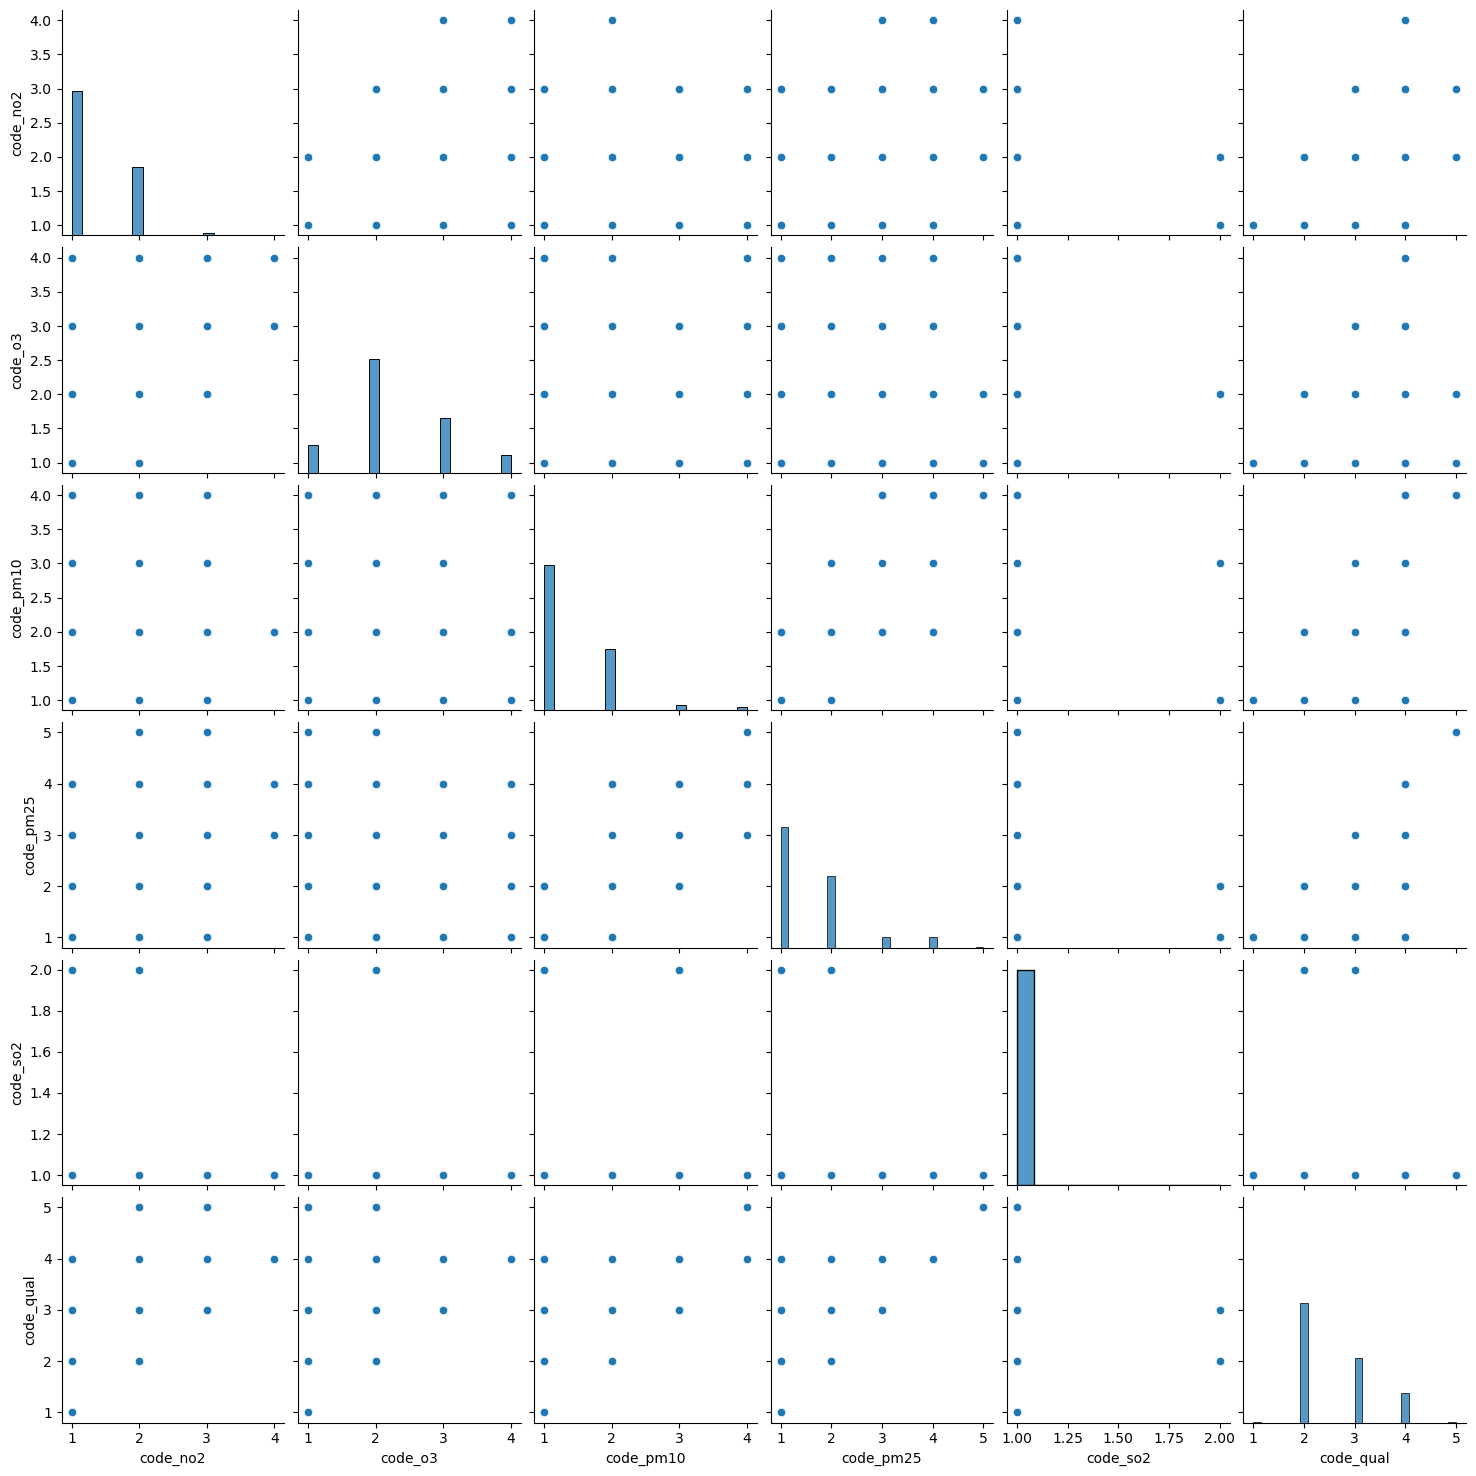

In [57]:
import seaborn as sns

# Créer une paire de graphiques de dispersion pour explorer les relations entre les variables
sns.pairplot(df_i[['code_no2', 'code_o3', 'code_pm10', 'code_pm25', 'code_so2', 'code_qual']])
plt.show()


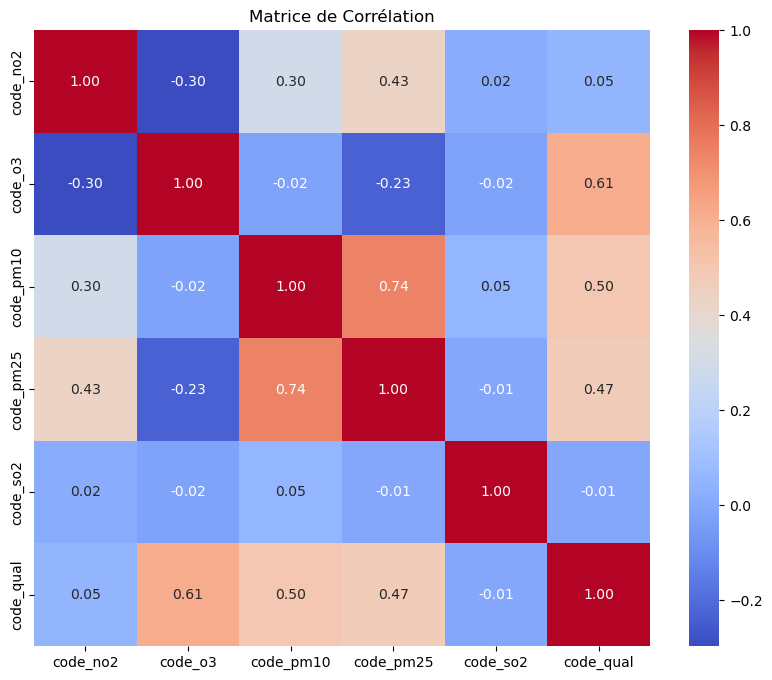

In [58]:
# Calculer la matrice de corrélation
correlation_matrix = df_i[['code_no2', 'code_o3', 'code_pm10', 'code_pm25', 'code_so2', 'code_qual']].corr()

# Visualiser la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matrice de Corrélation')
plt.show()


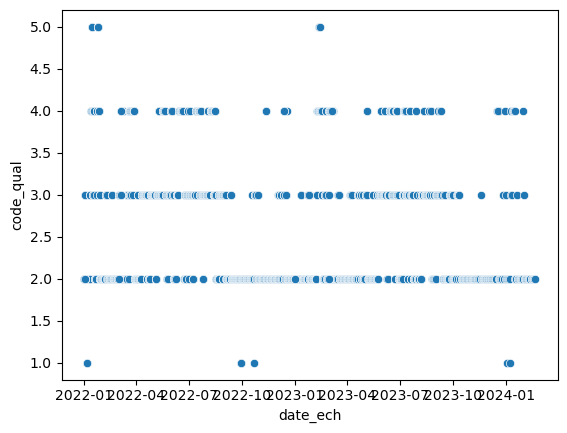

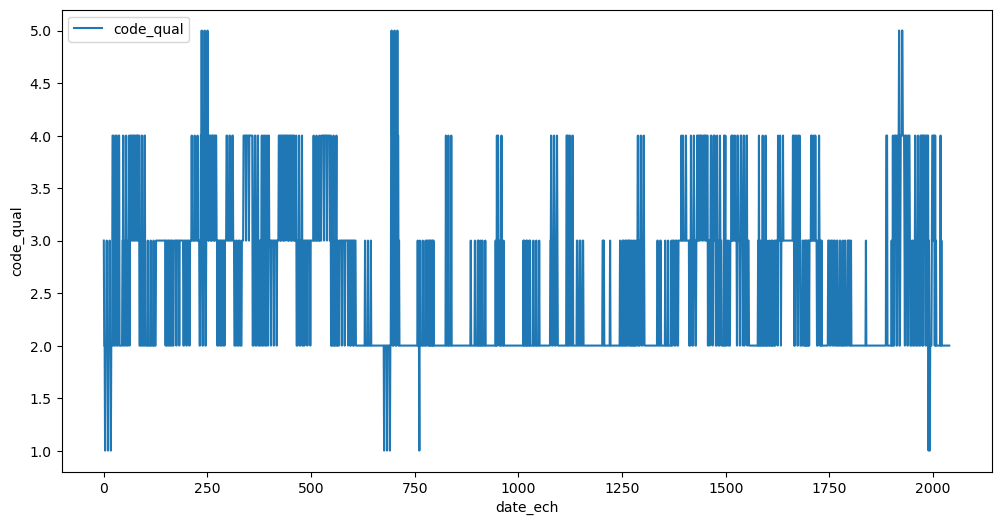

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la colonne 'date_ech' en format de date
df_i['date_ech'] = pd.to_datetime(df_i['date_ech'])

sns.scatterplot(data=df_i, x='date_ech', y='code_qual')

# Visualisation des prédictions
plt.figure(figsize=(12, 6))
plt.plot(df_i['code_qual'],label='code_qual')
plt.xlabel('date_ech')
plt.ylabel('code_qual')

plt.legend()
plt.show()

# REGION

In [69]:
nb_lignes, nb_colonnes = df_r.shape
print("Nombre de lignes :", nb_lignes)
print("Nombre de colonnes :", nb_colonnes)

Nombre de lignes : 96
Nombre de colonnes : 9


In [70]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          96 non-null     int32 
 1   superficie  96 non-null     object
 2   population  96 non-null     object
 3   pm25        96 non-null     object
 4   pm10        96 non-null     object
 5   nox         96 non-null     object
 6   code_pcaet  96 non-null     object
 7   ges         96 non-null     object
 8   code        96 non-null     object
dtypes: int32(1), object(8)
memory usage: 6.5+ KB


In [73]:
df_r.isnull().sum()

id            0
superficie    0
population    0
pm25          0
pm10          0
nox           0
code_pcaet    0
ges           0
code          0
dtype: int64

In [74]:
df_r.describe()

id
count  96.000000
mean   48.500000
std    27.856777
min     1.000000
25%    24.750000
50%    48.500000
75%    72.250000
max    96.000000

/home/bof/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


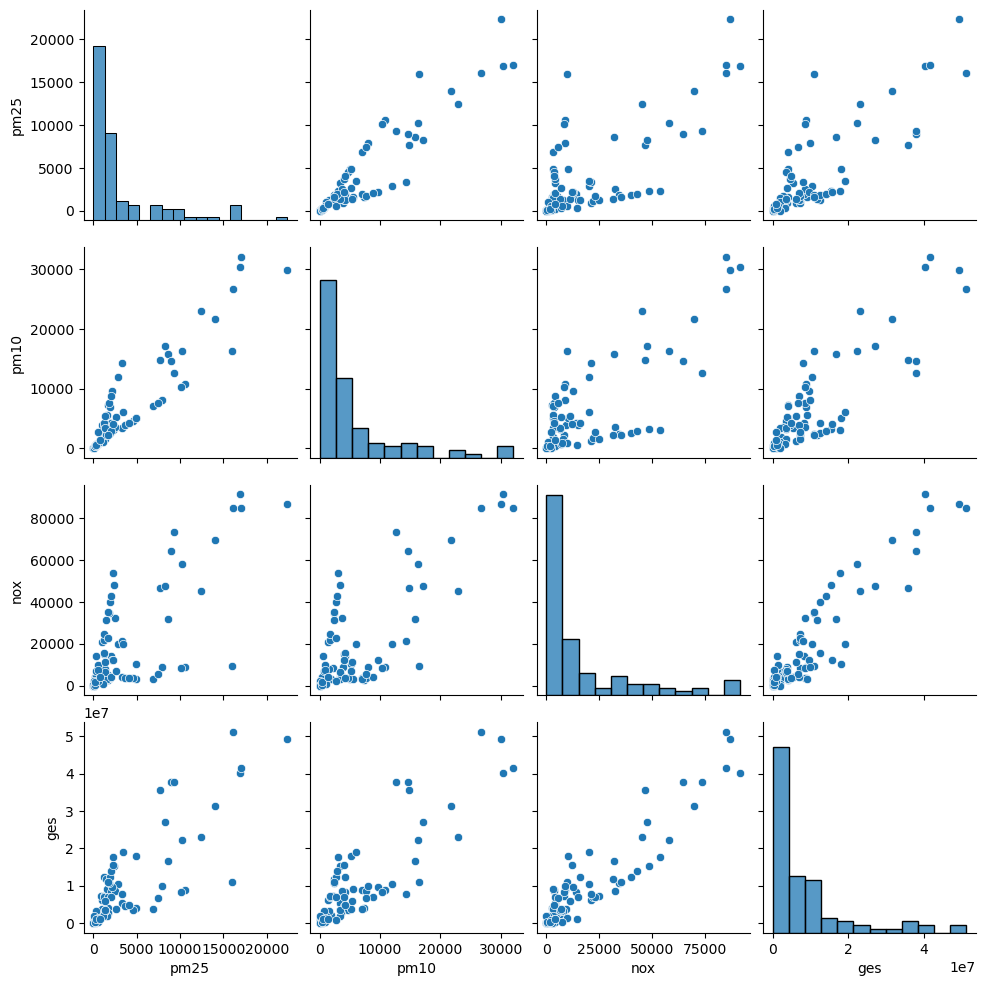

In [75]:
import seaborn as sns

# Sélection des variables d'intérêt
variables = ['pm25', 'pm10', 'nox', 'ges']

# Créer un pairplot
sns.pairplot(df_r[variables])
plt.show()


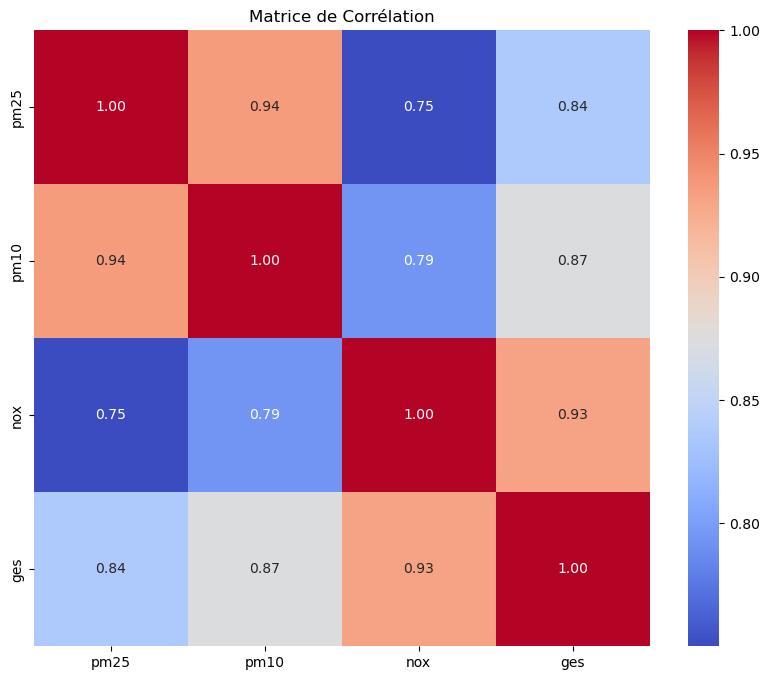

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
correlation_matrix = df_r[variables].corr()

# Créer un heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matrice de Corrélation')
plt.show()
